# Funcioes Utiles

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.circuits import InsertStrategy
# from cirq.contrib.svg import SVGCircuit #to print the circuit
# from cirq.contrib.svg import circuit_to_svg
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
from cairosvg import svg2png
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.datasets import make_imbalance
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from utils_code import prepare_ZFeatureMap, QuantumConv, RealAmplitudes, prepare_ZZFeatureMap, plot_history_list

2023-03-12 03:21:09.478729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-12 03:21:09.478773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-12 03:21:12.963710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-12 03:21:12.963755: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-12 03:21:12.963785: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mac-desktop): /proc/driver/nvidia/version does not exist


In [2]:
#read_data = prepare_ZFeatureMap
#ansatz = RealAmplitudes
#classes = len(np.unique(y))
#nn =  tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
classes = x_train = x_test = y_train = y_test  = 0
#x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)
def Train_model_with(read_data= prepare_ZFeatureMap,
                     ansatz = RealAmplitudes, 
                     nn= tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')]),
                     epochs = 150,
                     model_times = 3,
                     data_splitted = (x_train, x_test, y_train, y_test ) ):
    (x_train, x_test, y_train, y_test ) = data_splitted
    x_train_q = [read_data(x,reps = 3) for x in x_train]
    x_test_q = [read_data(x,reps = 3) for x in x_test]
    model_circuit = ansatz(num_qubits=5, reps=10)#), qubits_out=3)
    circuit_input = tf.keras.Input(shape = (), dtype = tf.string, name = 'circuits_input')
    q = cirq.GridQubit.rect(1, 5)
    measurement_ops = [cirq.Z(q[i]) for i in range(5) ] 
    circuit_layer = tfq.layers.PQC(model_circuit, measurement_ops)


    model = tf.keras.Model(inputs = circuit_input, outputs = nn(circuit_layer(circuit_input)) )

    print(model.summary())
    list_models = []

    # metrics
    f1_list = []
    precision_list = []
    recall_list = []
    accuracy_list = []

    for i in range(model_times):
        model = tf.keras.Model(inputs = circuit_input, outputs = nn(circuit_layer(circuit_input)) )
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
        model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        history = model.fit(x = tfq.convert_to_tensor(x_train_q), y = y_train, epochs = epochs, verbose = 1, validation_data= (tfq.convert_to_tensor(x_test_q),y_test) )
        list_models.append(history)

        y_pred = model.predict(tfq.convert_to_tensor(x_test_q))
        f1_score = sklearn.metrics.f1_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        precision_score = sklearn.metrics.precision_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        recall_score = sklearn.metrics.recall_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
        accuracy_score = sklearn.metrics.accuracy_score(y_test.argmax( axis=1), y_pred.argmax( axis=1))
        f1_list.append( f1_score )
        precision_list.append( precision_score )
        recall_list.append( recall_score )
        accuracy_list.append( accuracy_score )

    plot_history_list(list_models,name="QNN Hybrid {}".format(name_dataset) )

    print("f1 :", f1_list)
    print("f1 average:", np.mean(f1_list) )
    print("Precision :", precision_list)
    print("precision average:", np.mean(precision_list) )
    print("Recall :", recall_list)
    print("recall average:", np.mean(recall_list) )
    print("Accuracy :", accuracy_list)
    print("accuracy average:", np.mean(accuracy_list) )
    model.evaluate(tfq.convert_to_tensor(x_test_q), y_test)
    cm = confusion_matrix(y_test.argmax( axis=1), y_pred.argmax( axis=1), normalize='true')

    if classes == 3:  
        ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],yticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],)
    else:

        ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=range(classes),yticklabels=range(classes))
    
    ax.set_title('{} Confusion Matrix'.format(name_dataset));
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('True Label');
    #plt.savefig('/content/{}_CM.png'.format(name_dataset))
    plt.show()
    print("---------------------------------------------")
    print("---------------------------------------------")
    print("---------------------------------------------")

# Imports

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.circuits import InsertStrategy
# from cirq.contrib.svg import SVGCircuit #to print the circuit
# from cirq.contrib.svg import circuit_to_svg
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
from cairosvg import svg2png
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.datasets import make_imbalance
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from utils_code import prepare_ZFeatureMap, QuantumConv, RealAmplitudes, prepare_ZZFeatureMap, plot_history_list

# CWRU - 3 Clases

In [15]:
!ls

content			   CWRU_3Classes.npz  myenv	__pycache__
Create_model_cwru_3.ipynb  CWRU.ipynb	      pu_2.npz	utils_code.py
Create_model.ipynb	   CWRU_Quantum.npz   pu_4.npz
Create_model_pu.ipynb	   hol.py	      pu_5.npz
cwru_2.npz		   mfpt_2.npz	      PU.ipynb


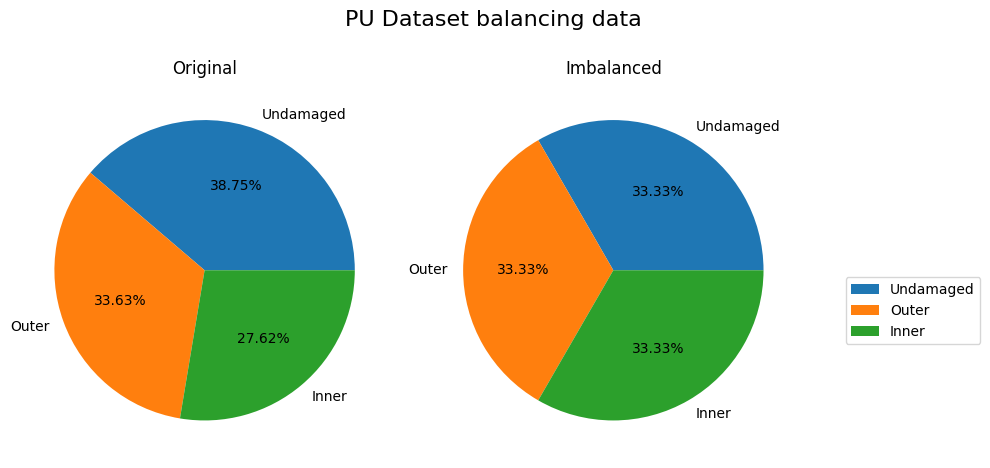

In [16]:
file_read = "pu_4.npz"  #  pu_2.npz cwru_2.npz
name_dataset = "PU Dataset" #"PU", "CWRU"
data_load = np.load(file_read)
try:
  X, y = data_load["x"], data_load["y"]
except:
  X, y = data_load["data"], data_load["label"]


min_samples_label =  min([sum(y == i)  for i in range(3) ])

sampling_strategy = {0: min_samples_label, 
                     1: min_samples_label, 
                     2: min_samples_label}
X, y = make_imbalance(X, y, sampling_strategy=sampling_strategy)
X = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(X)

labels = "Undamaged", "Outer", "Inner"
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
autopct = f"%.2f%%"
try:
    pd.DataFrame( data_load["y"]).value_counts().plot.pie(autopct=autopct, labels=labels, ax=axs[0], ylabel="")
except:
    pd.DataFrame( data_load["label"]).value_counts().plot.pie(autopct=autopct, labels=labels, ax=axs[0], ylabel="")
axs[0].set_title("Original")
pd.DataFrame( y ).value_counts().plot.pie(autopct=autopct, labels=labels,  ax=axs[1], ylabel="")
axs[1].set_title("Imbalanced")
plt.legend(labels,bbox_to_anchor=(1.1,0.5) )

fig.suptitle("{} balancing data".format(name_dataset), fontsize=16)
fig.tight_layout()

y = y.astype(int)
# Code a function to perform preprocessing on the classical dataset
def prepare_classic_dataset(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
    scaler = MinMaxScaler(feature_range = (0, np.pi))                                                  #o valor de cada característica é classificada como o angulo do qubit, portanto, em vez de normalizar entre 0 e 1, normalizamos entre 0 e pi
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)                                                                  #só o transform, se não vai contaminar os dados de teste
     
    classes = len(np.unique(y))

    y_train = np.eye(classes)[y_train]                                                                      #one hot encoder para otimizar, tem 3 características dos dados de treinamento (0, 1, 2 - modos de falha)
    y_test = np.eye(classes)[y_test]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

In [17]:
sampling_strategy

{0: 787, 1: 787, 2: 787}

Text(0.5, 1.0, 'PU Dataset')

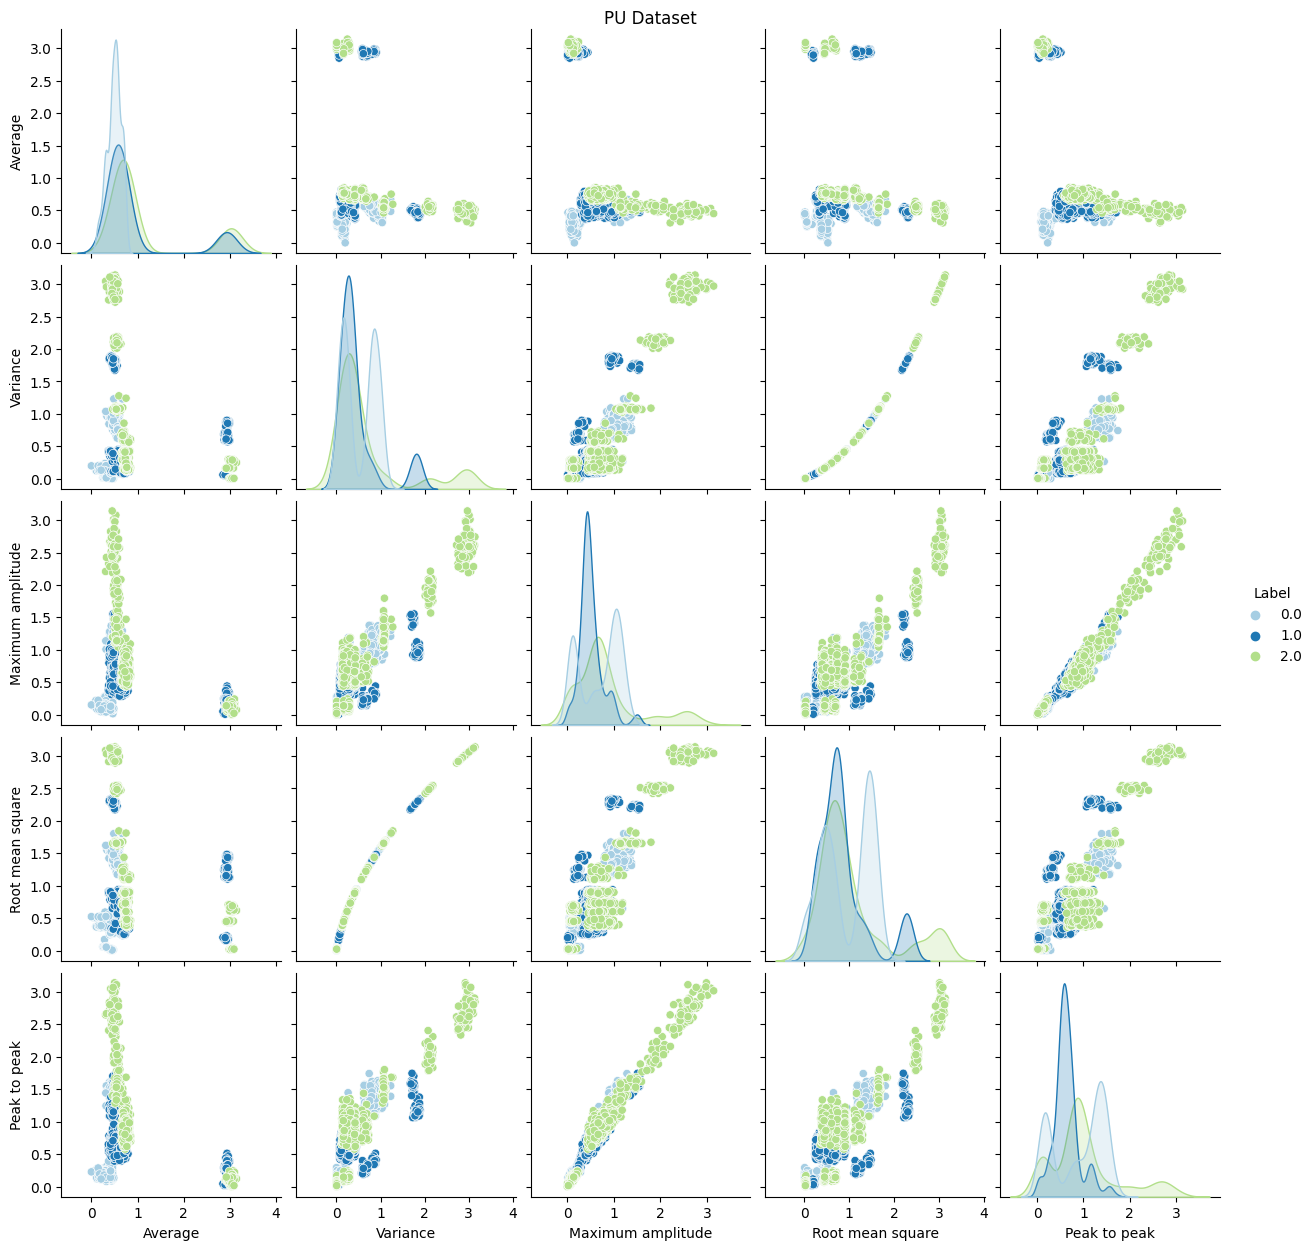

In [18]:
data_df = pd.DataFrame(np.hstack( ( X ,y.reshape(-1,1)) ), columns = ["Average","Variance","Maximum amplitude","Root mean square","Peak to peak","Label"])
p = sns.pairplot(data_df, hue = "Label", palette = "Paired")
p.fig.suptitle(name_dataset, y=1.0)

# Sin MLP

In [19]:
# Se crea una capa constante que es solo para seleccionar los 3 primeros qubits
class constant_layer(tf.keras.layers.Layer):
  def __init__(self):
    super(constant_layer, self).__init__()
  def build(self, input_shape):
    self.kernel =   tf.constant([[1,0,0],[0,1,0],[0,0,1],[0,0,0],[0,0,0]], dtype='float32')
  def call(self, inputs):
    return tf.matmul( inputs, self.kernel)
 
nn = tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_4 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_7 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
52/52 [==============================] - 12s 208ms/step - loss: 1.0070 - accuracy: 0.5847 - val_loss: 0.9813 - val_accuracy: 0.6305
Epoch 2/50
52/52 [==============================] - 11s 214ms/step - loss: 0.9445 - accuracy: 0.6301 - val_loss: 0.9591 - val_accuracy: 0.5755
Epoch 3/50
52/52 [=================

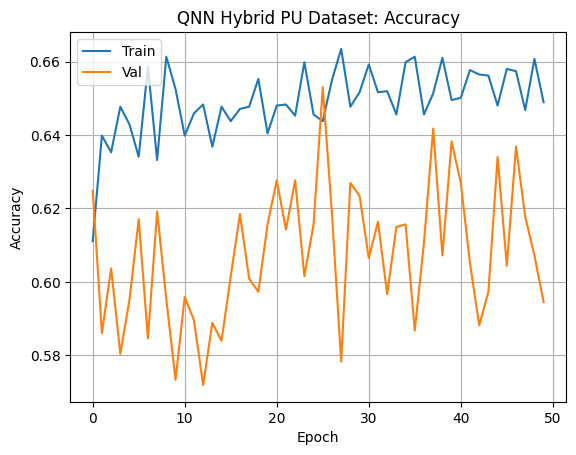

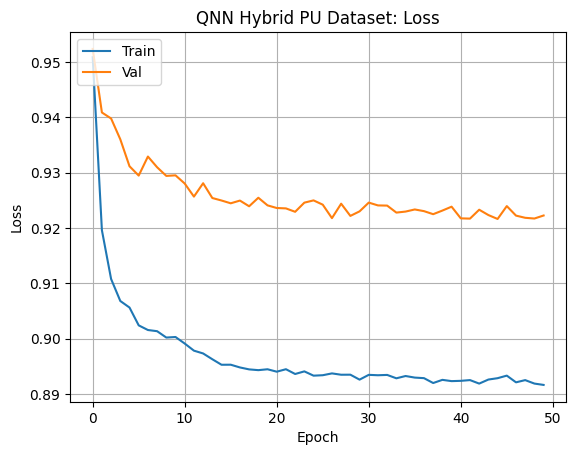

accuracy
[0.6404358148574829, 0.657384991645813]
mean: 0.648910403251648
devest: 0.008474588394165039
val_accuracy
[0.593794047832489, 0.5952045321464539]
mean: 0.5944992899894714
devest: 0.0007052421569824219
loss
[0.894188404083252, 0.8890382051467896]
mean: 0.8916133046150208
devest: 0.002575099468231201
val_loss
[0.924124538898468, 0.9204055070877075]
mean: 0.9222650229930878
devest: 0.001859515905380249
f1 : [0.5937940761636107, 0.5952045133991537]
f1 average: 0.5944992947813822
Precision : [0.5937940761636107, 0.5952045133991537]
precision average: 0.5944992947813822
Recall : [0.5937940761636107, 0.5952045133991537]
recall average: 0.5944992947813822
Accuracy : [0.5937940761636107, 0.5952045133991537]
accuracy average: 0.5944992947813822
23/23 [==============================] - 2s 99ms/step - loss: 0.9204 - accuracy: 0.5952


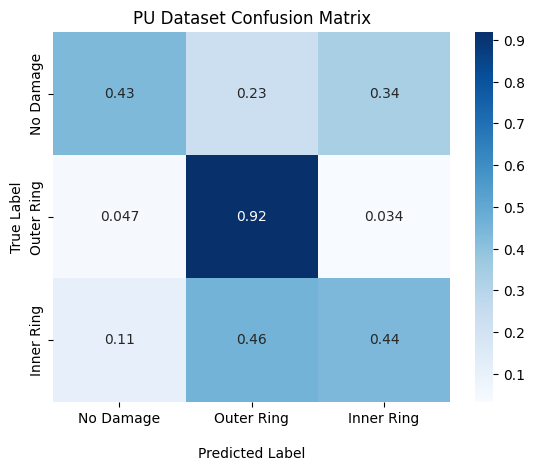

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [22]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 50,
                model_times = 2,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_5 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_8 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
52/52 [==============================] - 15s 274ms/step - loss: 0.9891 - accuracy: 0.6544 - val_loss: 0.9286 - val_accuracy: 0.7560
Epoch 2/50
52/52 [==============================] - 14s 270ms/step - loss: 0.9000 - accuracy: 0.7966 - val_loss: 0.8908 - val_accuracy: 0.7884
Epoch 3/50
52/52 [=================

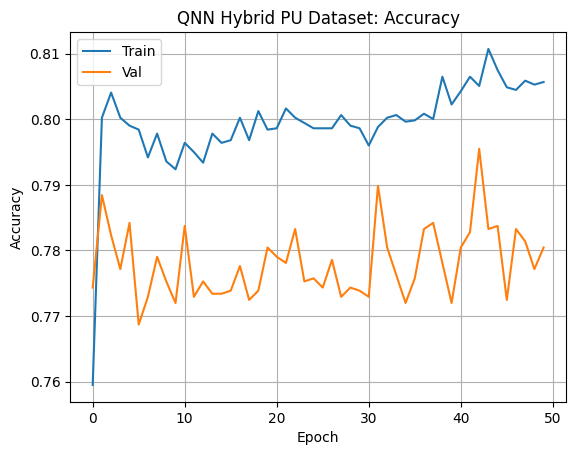

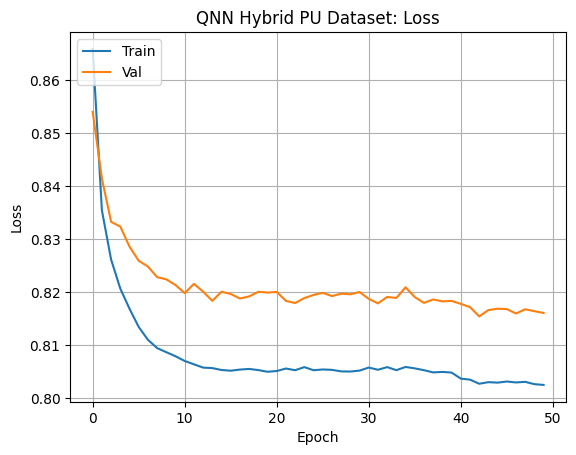

accuracy
[0.8135592937469482, 0.8020581007003784, 0.8014527559280396]
mean: 0.8056900501251221
devest: 0.005569880726316523
val_accuracy
[0.7856135368347168, 0.7799717783927917, 0.7757405042648315]
mean: 0.78044193983078
devest: 0.004044336110730014
loss
[0.8067086338996887, 0.8006190657615662, 0.8002374768257141]
mean: 0.8025217254956564
devest: 0.0029646870567632106
val_loss
[0.8173937201499939, 0.8150296211242676, 0.8158352971076965]
mean: 0.816086212793986
devest: 0.0009813120679578672
f1 : [0.7856135401974612, 0.7799717912552891, 0.7757404795486601]
f1 average: 0.7804419370004702
Precision : [0.7856135401974612, 0.7799717912552891, 0.7757404795486601]
precision average: 0.7804419370004702
Recall : [0.7856135401974612, 0.7799717912552891, 0.7757404795486601]
recall average: 0.7804419370004702
Accuracy : [0.7856135401974612, 0.7799717912552891, 0.7757404795486601]
accuracy average: 0.7804419370004702
23/23 [==============================] - 3s 125ms/step - loss: 0.8158 - accuracy: 0

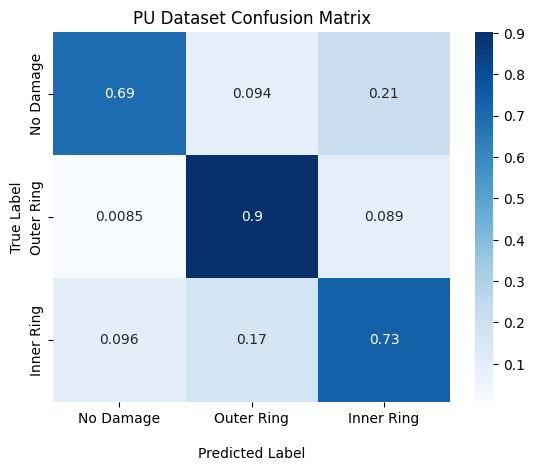

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [23]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 50,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_6 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_9 (Sequential)   (None, 3)                 0         
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
52/52 [==============================] - 95s 2s/step - loss: 0.9335 - accuracy: 0.6144 - val_loss: 0.9141 - val_accuracy: 0.6248
Epoch 2/50
52/52 [==============================] - 93s 2s/step - loss: 0.8710 - accuracy: 0.6840 - val_loss: 0.8860 - val_accuracy: 0.6897
Epoch 3/50
52/52 [=====================

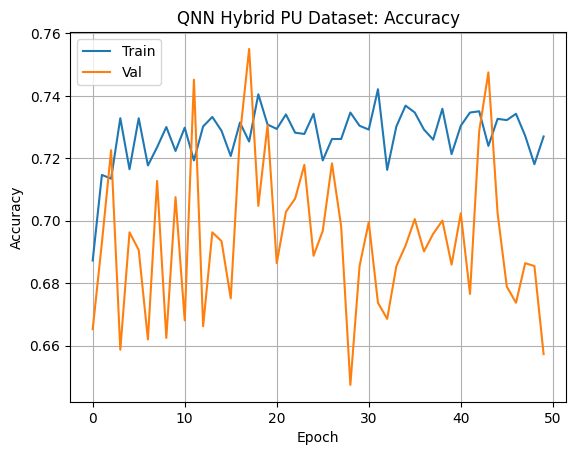

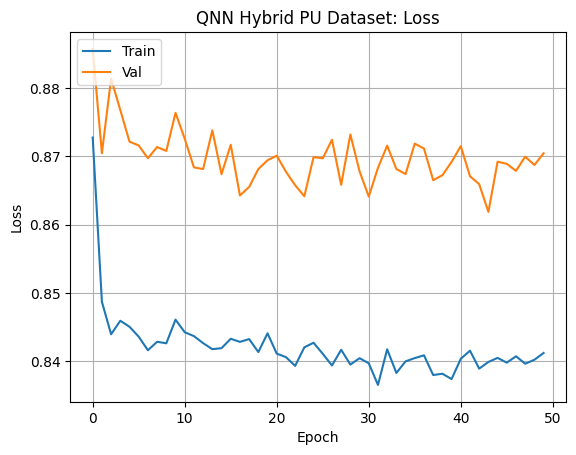

accuracy
[0.7263922691345215, 0.7239709496498108, 0.730629563331604]
mean: 0.7269975940386454
devest: 0.0027518597009423083
val_accuracy
[0.6516219973564148, 0.6502115726470947, 0.66995769739151]
mean: 0.6572637557983398
devest: 0.0089944219507899
loss
[0.8473559617996216, 0.8374198079109192, 0.8389055132865906]
mean: 0.8412270943323771
devest: 0.004376002166293675
val_loss
[0.8701128959655762, 0.8673667311668396, 0.873924195766449]
mean: 0.8704679409662882
devest: 0.0026888198412662405
f1 : [0.6516220028208745, 0.6502115655853314, 0.6699576868829337]
f1 average: 0.6572637517630465
Precision : [0.6516220028208745, 0.6502115655853314, 0.6699576868829337]
precision average: 0.6572637517630465
Recall : [0.6516220028208745, 0.6502115655853314, 0.6699576868829337]
recall average: 0.6572637517630465
Accuracy : [0.6516220028208745, 0.6502115655853314, 0.6699576868829337]
accuracy average: 0.6572637517630465
23/23 [==============================] - 20s 858ms/step - loss: 0.8739 - accuracy: 0.6

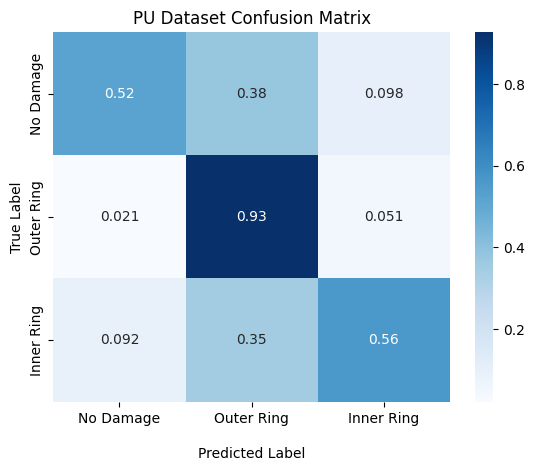

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [24]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 50,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_7 (PQC)                 (None, 5)                 408       
                                                                 
 sequential_10 (Sequential)  (None, 3)                 0         
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
52/52 [==============================] - 98s 2s/step - loss: 0.8484 - accuracy: 0.7488 - val_loss: 0.7817 - val_accuracy: 0.7828
Epoch 2/50
52/52 [==============================] - 99s 2s/step - loss: 0.7448 - accuracy: 0.8184 - val_loss: 0.7366 - val_accuracy: 0.8293
Epoch 3/50
52/52 [=====================

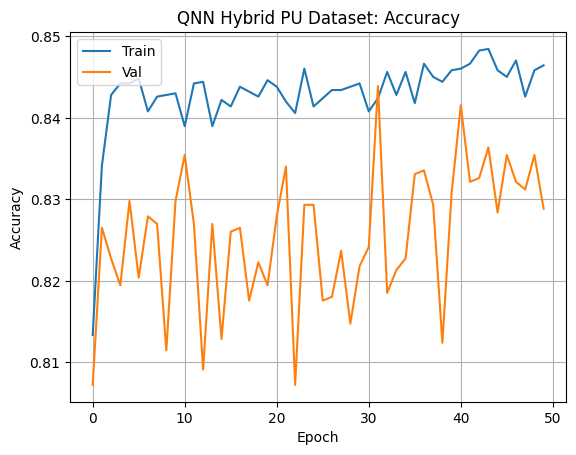

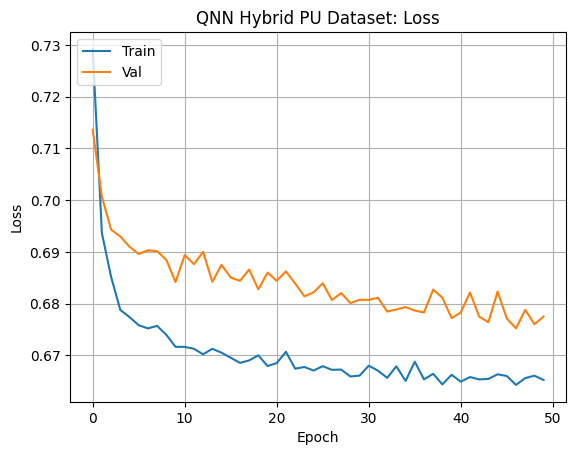

accuracy
[0.8353511095046997, 0.8547215461730957, 0.8492736220359802]
mean: 0.8464487592379252
devest: 0.008156320312165344
val_accuracy
[0.8053596615791321, 0.8448519110679626, 0.8363893032073975]
mean: 0.8288669586181641
devest: 0.016977410354377494
loss
[0.6707006096839905, 0.6606501936912537, 0.6643597483634949]
mean: 0.6652368505795797
devest: 0.004149674415329524
val_loss
[0.6847683787345886, 0.6725896596908569, 0.6751136779785156]
mean: 0.6774905721346537
devest: 0.005248334260102649
f1 : [0.8053596614950634, 0.844851904090268, 0.8363892806770099]
f1 average: 0.8288669487541137
Precision : [0.8053596614950634, 0.844851904090268, 0.8363892806770099]
precision average: 0.8288669487541137
Recall : [0.8053596614950634, 0.844851904090268, 0.8363892806770099]
recall average: 0.8288669487541137
Accuracy : [0.8053596614950634, 0.844851904090268, 0.8363892806770099]
accuracy average: 0.8288669487541137
23/23 [==============================] - 21s 930ms/step - loss: 0.6751 - accuracy: 0.8

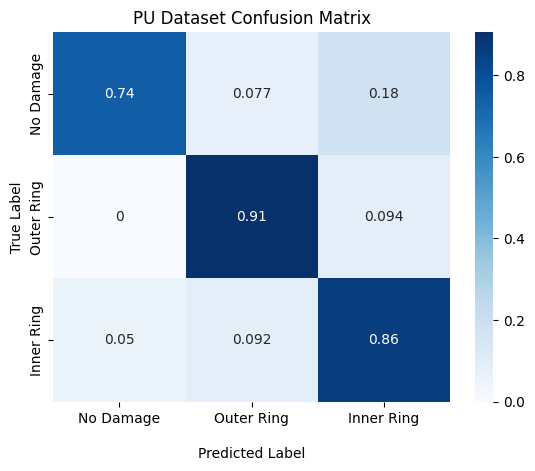

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [25]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn =  tf.keras.Sequential([constant_layer(), tf.keras.layers.Softmax()])
 #tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 50,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

# CON MLP

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_8 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_11 (Sequential)  (None, 3)                 903       
                                                                 
Total params: 958
Trainable params: 958
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
52/52 [==============================] - 12s 213ms/step - loss: 0.8109 - accuracy: 0.6695 - val_loss: 0.6240 - val_accuracy: 0.7475
Epoch 2/150
52/52 [==============================] - 11s 207ms/step - loss: 0.5334 - accuracy: 0.8220 - val_loss: 0.4646 - val_accuracy: 0.8449
Epoch 3/150
52/52 [============

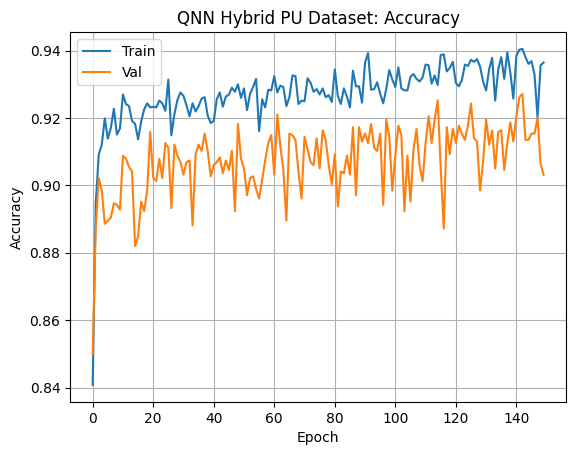

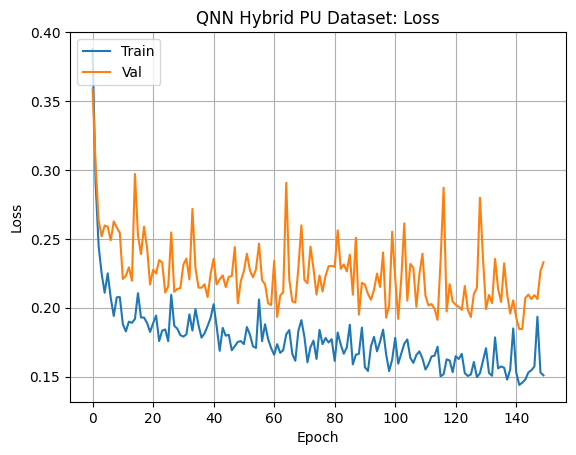

accuracy
[0.917070209980011, 0.9412832856178284, 0.9509685039520264]
mean: 0.936440666516622
devest: 0.014256268875429755
val_accuracy
[0.9069111347198486, 0.8772919774055481, 0.9252468347549438]
mean: 0.9031499822934469
devest: 0.019757307281631182
loss
[0.18369923532009125, 0.14757908880710602, 0.1213604062795639]
mean: 0.15087957680225372
devest: 0.025556503637894985
val_loss
[0.20712049305438995, 0.30945706367492676, 0.1826162338256836]
mean: 0.23306459685166678
devest: 0.05493615336973196
f1 : [0.9069111424541608, 0.8772919605077575, 0.9252468265162201]
f1 average: 0.9031499764927128
Precision : [0.9069111424541608, 0.8772919605077574, 0.92524682651622]
precision average: 0.9031499764927128
Recall : [0.9069111424541608, 0.8772919605077574, 0.92524682651622]
recall average: 0.9031499764927128
Accuracy : [0.9069111424541608, 0.8772919605077574, 0.92524682651622]
accuracy average: 0.9031499764927128
23/23 [==============================] - 2s 95ms/step - loss: 0.1826 - accuracy: 0.92

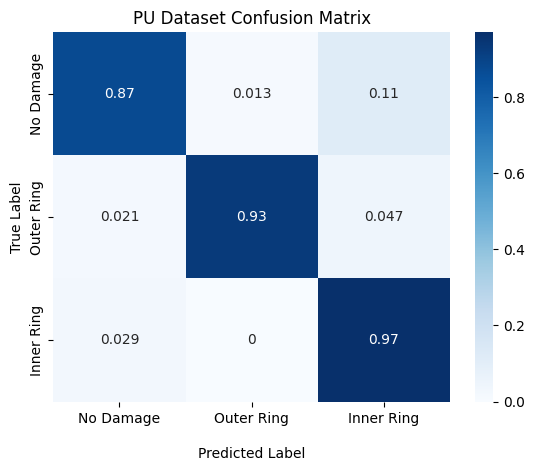

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [26]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_9 (PQC)                 (None, 5)                 55        
                                                                 
 sequential_12 (Sequential)  (None, 3)                 903       
                                                                 
Total params: 958
Trainable params: 958
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
52/52 [==============================] - 15s 284ms/step - loss: 0.6915 - accuracy: 0.7203 - val_loss: 0.4383 - val_accuracy: 0.8166
Epoch 2/150
52/52 [==============================] - 14s 278ms/step - loss: 0.3931 - accuracy: 0.8511 - val_loss: 0.3225 - val_accuracy: 0.8674
Epoch 3/150
52/52 [============

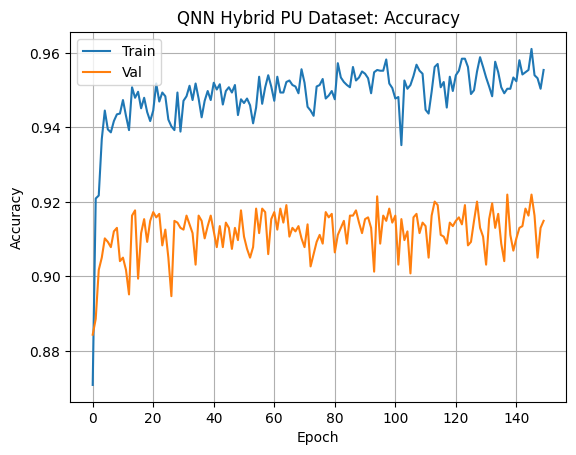

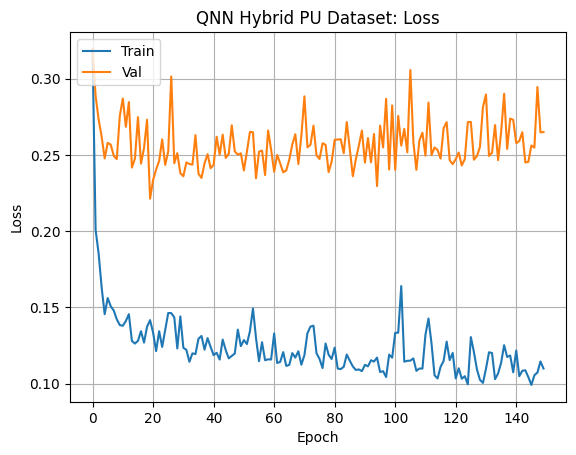

accuracy
[0.9497578740119934, 0.9582324624061584, 0.9582324624061584]
mean: 0.9554075996081034
devest: 0.00399495928085261
val_accuracy
[0.9196050763130188, 0.9139633178710938, 0.9111424684524536]
mean: 0.9149036208788554
devest: 0.0035182439047749476
loss
[0.12543198466300964, 0.09887626022100449, 0.10546007007360458]
mean: 0.10992277165253957
devest: 0.011291247471586097
val_loss
[0.2389519065618515, 0.29039716720581055, 0.2655637562274933]
mean: 0.26497094333171844
devest: 0.021006622464170167
f1 : [0.919605077574048, 0.9139633286318759, 0.9111424541607899]
f1 average: 0.9149036201222379
Precision : [0.919605077574048, 0.9139633286318759, 0.9111424541607899]
precision average: 0.9149036201222379
Recall : [0.919605077574048, 0.9139633286318759, 0.9111424541607899]
recall average: 0.9149036201222379
Accuracy : [0.919605077574048, 0.9139633286318759, 0.9111424541607899]
accuracy average: 0.9149036201222379
23/23 [==============================] - 3s 134ms/step - loss: 0.2656 - accuracy

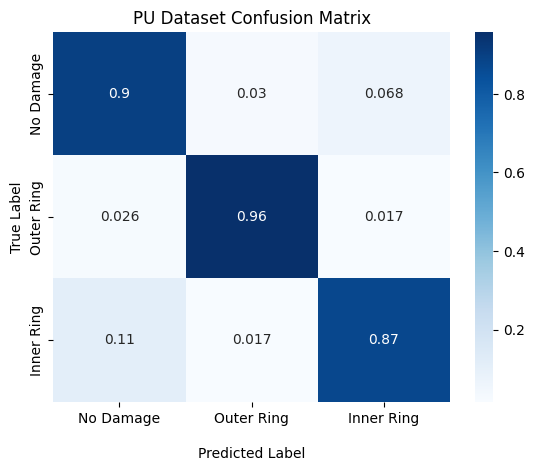

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [27]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = RealAmplitudes
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_10 (PQC)                (None, 5)                 408       
                                                                 
 sequential_13 (Sequential)  (None, 3)                 903       
                                                                 
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
52/52 [==============================] - 98s 2s/step - loss: 0.7397 - accuracy: 0.7107 - val_loss: 0.5843 - val_accuracy: 0.7983
Epoch 2/150
52/52 [==============================] - 96s 2s/step - loss: 0.5018 - accuracy: 0.8323 - val_loss: 0.3998 - val_accuracy: 0.8660
Epoch 3/150
52/52 [==============

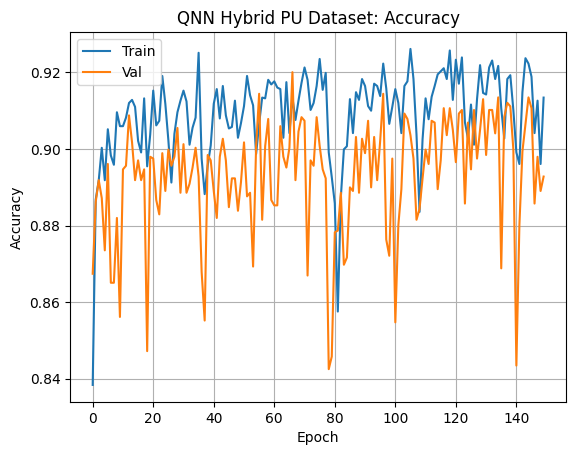

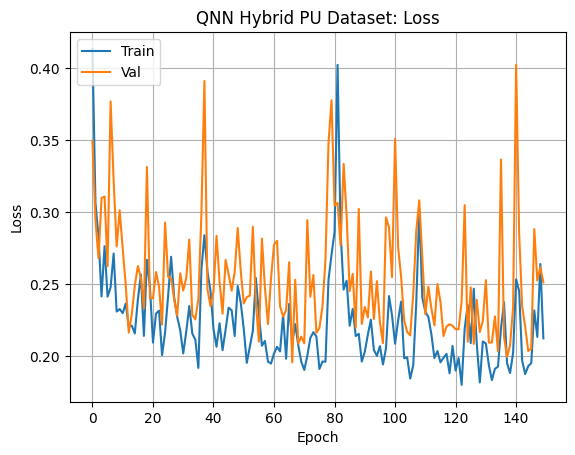

accuracy
[0.897699773311615, 0.9219128489494324, 0.9207021594047546]
mean: 0.9134382605552673
devest: 0.011139761452633045
val_accuracy
[0.8533145189285278, 0.9238364100456238, 0.9012693762779236]
mean: 0.8928067684173584
devest: 0.02940573731472776
loss
[0.25742843747138977, 0.17926891148090363, 0.19972650706768036]
mean: 0.21214128533999124
devest: 0.03309403687904466
val_loss
[0.30668389797210693, 0.19097448885440826, 0.25562700629234314]
mean: 0.25109513103961945
devest: 0.04734673701936547
f1 : [0.8533145275035261, 0.923836389280677, 0.9012693935119888]
f1 average: 0.8928067700987307
Precision : [0.8533145275035261, 0.923836389280677, 0.9012693935119888]
precision average: 0.8928067700987307
Recall : [0.8533145275035261, 0.923836389280677, 0.9012693935119888]
recall average: 0.8928067700987307
Accuracy : [0.8533145275035261, 0.923836389280677, 0.9012693935119888]
accuracy average: 0.8928067700987307
23/23 [==============================] - 21s 905ms/step - loss: 0.2556 - accuracy:

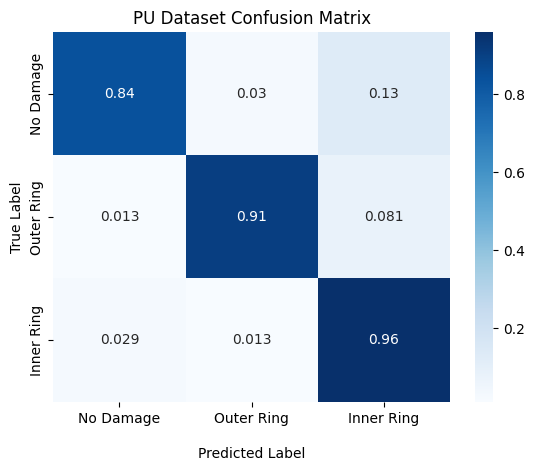

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [28]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 circuits_input (InputLayer)  [(None,)]                0         
                                                                 
 pqc_11 (PQC)                (None, 5)                 408       
                                                                 
 sequential_14 (Sequential)  (None, 3)                 903       
                                                                 
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
52/52 [==============================] - 106s 2s/step - loss: 0.5709 - accuracy: 0.7651 - val_loss: 0.2969 - val_accuracy: 0.8872
Epoch 2/150
52/52 [==============================] - 104s 2s/step - loss: 0.2943 - accuracy: 0.8838 - val_loss: 0.3003 - val_accuracy: 0.8914
Epoch 3/150
52/52 [============

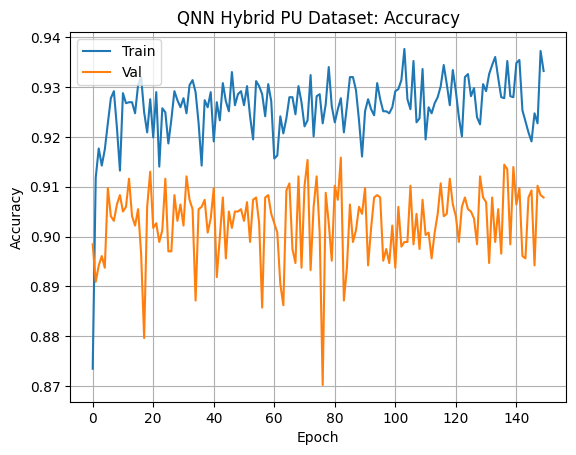

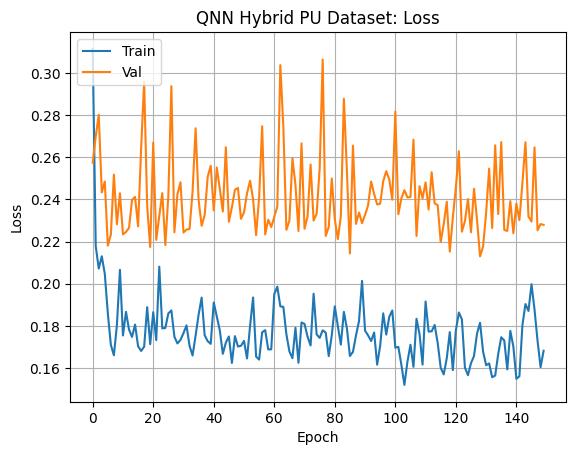

accuracy
[0.9315980672836304, 0.9376513361930847, 0.9303874373435974]
mean: 0.9332122802734375
devest: 0.003177558738638023
val_accuracy
[0.9153737425804138, 0.9083215594291687, 0.8998589515686035]
mean: 0.9078514178593954
devest: 0.006342605135471237
loss
[0.16139855980873108, 0.17002247273921967, 0.17306989431381226]
mean: 0.16816364228725433
devest: 0.004942769147568992
val_loss
[0.20986036956310272, 0.2285403162240982, 0.24527117609977722]
mean: 0.2278906206289927
devest: 0.01446369900058239
f1 : [0.9153737658674189, 0.9083215796897038, 0.8998589562764457]
f1 average: 0.9078514339445228
Precision : [0.9153737658674189, 0.9083215796897038, 0.8998589562764457]
precision average: 0.9078514339445228
Recall : [0.9153737658674189, 0.9083215796897038, 0.8998589562764457]
recall average: 0.9078514339445228
Accuracy : [0.9153737658674189, 0.9083215796897038, 0.8998589562764457]
accuracy average: 0.9078514339445228
23/23 [==============================] - 19s 844ms/step - loss: 0.2453 - accu

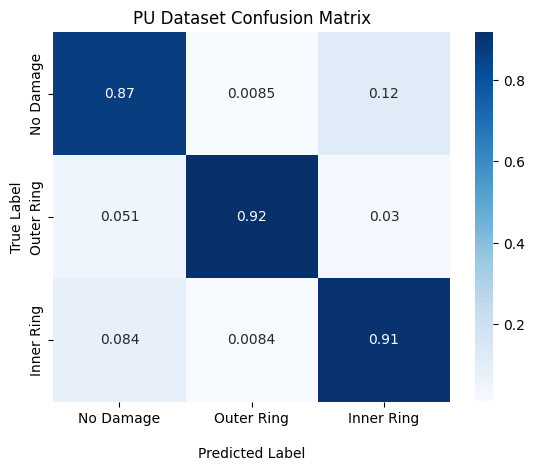

---------------------------------------------
---------------------------------------------
---------------------------------------------


In [29]:
x_train, x_test, y_train, y_test = prepare_classic_dataset(X,y)

read_data = prepare_ZZFeatureMap
ansatz = QuantumConv
classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])
Train_model_with(read_data= read_data,
                ansatz = ansatz, 
                nn= nn,
                epochs = 150,
                model_times = 3,
                data_splitted = (x_train, x_test, y_train, y_test ) )

# Only MLP

Epoch 1/150
52/52 [==============================] - 1s 6ms/step - loss: 0.9705 - accuracy: 0.4921 - val_loss: 0.8878 - val_accuracy: 0.5896
Epoch 2/150
52/52 [==============================] - 0s 3ms/step - loss: 0.8011 - accuracy: 0.6659 - val_loss: 0.7571 - val_accuracy: 0.6953
Epoch 3/150
52/52 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.7258 - val_loss: 0.6348 - val_accuracy: 0.7701
Epoch 4/150
52/52 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.7742 - val_loss: 0.5897 - val_accuracy: 0.7814
Epoch 5/150
52/52 [==============================] - 0s 3ms/step - loss: 0.5393 - accuracy: 0.7930 - val_loss: 0.5329 - val_accuracy: 0.7772
Epoch 6/150
52/52 [==============================] - 0s 3ms/step - loss: 0.5025 - accuracy: 0.8069 - val_loss: 0.5029 - val_accuracy: 0.8110
Epoch 7/150
52/52 [==============================] - 0s 3ms/step - loss: 0.4753 - accuracy: 0.8166 - val_loss: 0.4857 - val_accuracy: 0.8223
Epoch 8/150
5

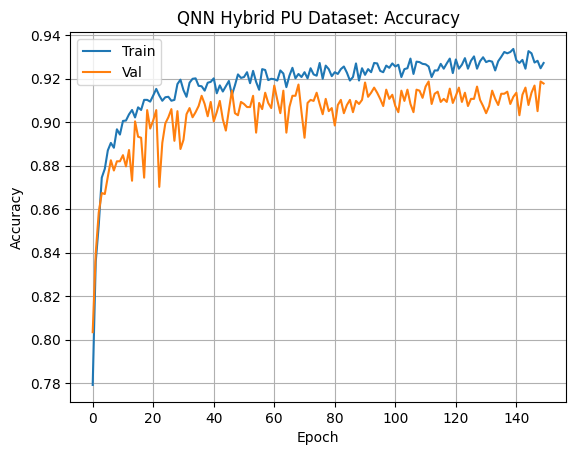

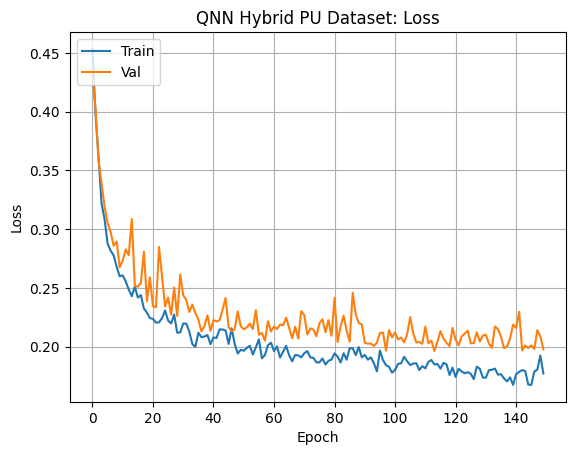

accuracy
[0.9092009663581848, 0.9237288236618042, 0.9485472440719604]
mean: 0.9271590113639832
devest: 0.016245143545821607
val_accuracy
[0.9026798009872437, 0.9125528931617737, 0.937940776348114]
mean: 0.9177244901657104
devest: 0.014852455633739997
loss
[0.2237088531255722, 0.17857933044433594, 0.12915249168872833]
mean: 0.17714689175287882
devest: 0.038615759153462645
val_loss
[0.22218923270702362, 0.19551081955432892, 0.17529165744781494]
mean: 0.19766390323638916
devest: 0.019206291821601086
f1 : [0.9026798307475318, 0.9125528913963329, 0.9379407616361072]
f1 average: 0.917724494593324
Precision : [0.9026798307475318, 0.9125528913963329, 0.9379407616361072]
precision average: 0.917724494593324
Recall : [0.9026798307475318, 0.9125528913963329, 0.9379407616361072]
recall average: 0.917724494593324
Accuracy : [0.9026798307475318, 0.9125528913963329, 0.9379407616361072]
accuracy average: 0.917724494593324
23/23 [==============================] - 0s 1ms/step - loss: 0.1753 - accuracy: 

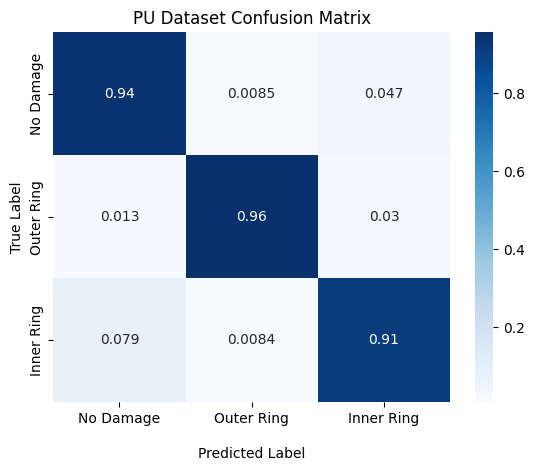

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)
scaler = MinMaxScaler(feature_range = (0, 1))                                                  #o valor de cada característica é classificada como o angulo do qubit, portanto, em vez de normalizar entre 0 e 1, normalizamos entre 0 e pi
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)                                                                  #só o transform, se não vai contaminar os dados de teste
    
classes = len(np.unique(y))

y_train = np.eye(classes)[y_train]                                                                      #one hot encoder para otimizar, tem 3 características dos dados de treinamento (0, 1, 2 - modos de falha)
y_test = np.eye(classes)[y_test]

classes = len(np.unique(y))
nn = tf.keras.Sequential([tf.keras.layers.Dense(100,activation = 'relu'), tf.keras.layers.Dense(classes,activation = 'softmax')])

model = nn#tf.keras.Model(outputs = nn())

#print(model.summary())
list_models = []

# metrics
f1_list = []
precision_list = []
recall_list = []
accuracy_list = []
model_times = 3 
for i in range(model_times):
    model = nn#tf.keras.Model(inputs = nn(), outputs = nn() )
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history = model.fit(x = x_train, y = y_train, epochs = 150, verbose = 1, validation_data= (x_test,y_test) )
    list_models.append(history)

    y_pred = model.predict(x_test)
    f1_score = sklearn.metrics.f1_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    precision_score = sklearn.metrics.precision_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    recall_score = sklearn.metrics.recall_score(y_test.argmax( axis=1), y_pred.argmax( axis=1), average='micro')
    accuracy_score = sklearn.metrics.accuracy_score(y_test.argmax( axis=1), y_pred.argmax( axis=1))
    f1_list.append( f1_score )
    precision_list.append( precision_score )
    recall_list.append( recall_score )
    accuracy_list.append( accuracy_score )

plot_history_list(list_models,name="QNN Hybrid {}".format(name_dataset) )

print("f1 :", f1_list)
print("f1 average:", np.mean(f1_list) )
print("Precision :", precision_list)
print("precision average:", np.mean(precision_list) )
print("Recall :", recall_list)
print("recall average:", np.mean(recall_list) )
print("Accuracy :", accuracy_list)
print("accuracy average:", np.mean(accuracy_list) )
model.evaluate(x_test, y_test)
cm = confusion_matrix(y_test.argmax( axis=1), y_pred.argmax( axis=1), normalize='true')

if classes == 3:  
    ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],yticklabels=['No Damage', 'Outer Ring', 'Inner Ring'],)
else:

    ax = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=range(classes),yticklabels=range(classes))

ax.set_title('{} Confusion Matrix'.format(name_dataset));
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');
#plt.savefig('/content/{}_CM.png'.format(name_dataset))
plt.show()